# Creating complex sparsity patterns with xformers

`xformers` contains optimized GPU implementations for sparse transformers, which are specially useful when dealing with large sequences like images.

In this notebook, we illustrate how one can leverage some helper functions from `xformers` to construct complex sparsity patterns via a particular structure of the `attn_mask`, which are enough to re-implement axial attention, local 2d attention and many more.

Let's start with some imports

In [1]:
import matplotlib.pyplot as plt
import torch
import xformers.components.attention.attention_patterns as AP

%matplotlib inline

Let's assume our sequence length is `H * W`, and let's select the middle point in the `(H * W) ** 2` for visualization purposes

In [2]:
H, W = 20, 30
middle_point = H * W // 2 + W // 2

## Axial attention

Different instantiations of the [axial attention](https://arxiv.org/abs/1912.12180) for images can be obtained via the following helper functions.

They create distance matrices that can be used to generate the axial attention at a given distance

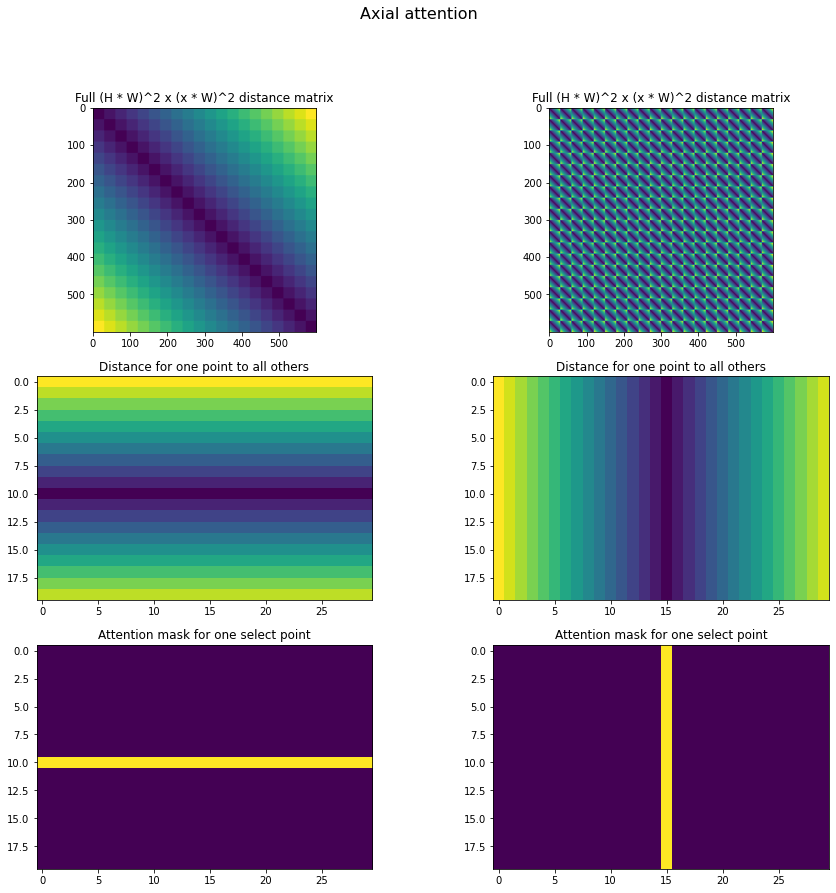

In [3]:
hoz_dist = AP.horizontal_axial_2d_distance(H, W)
vert_dist = AP.vertical_axial_2d_distance(H, W)

fig, axs = plt.subplots(3, 2, figsize=(15, 14))
# full distance matrix between every two points
axs[0, 0].imshow(hoz_dist)
axs[0, 0].set_title("Full (H * W)^2 x (x * W)^2 distance matrix")
axs[0, 1].imshow(vert_dist)
axs[0, 1].set_title("Full (H * W)^2 x (x * W)^2 distance matrix")

# select one point in the matrix and see the corresponding distance
# for all other points
axs[1, 0].imshow(hoz_dist[middle_point].reshape(H, W))
axs[1, 0].set_title("Distance for one point to all others")
axs[1, 1].imshow(vert_dist[middle_point].reshape(H, W))
axs[1, 1].set_title("Distance for one point to all others")

# standard instantiation of separate axial attention for a given point
axs[2, 0].imshow(hoz_dist[middle_point].reshape(H, W) < 1)
axs[2, 0].set_title("Attention mask for one select point")
axs[2, 1].imshow(vert_dist[middle_point].reshape(H, W) < 1)
axs[2, 1].set_title("Attention mask for one select point")

fig.suptitle('Axial attention', fontsize=16)
plt.show()

For the vanilla axial attention, we have the following convenience function

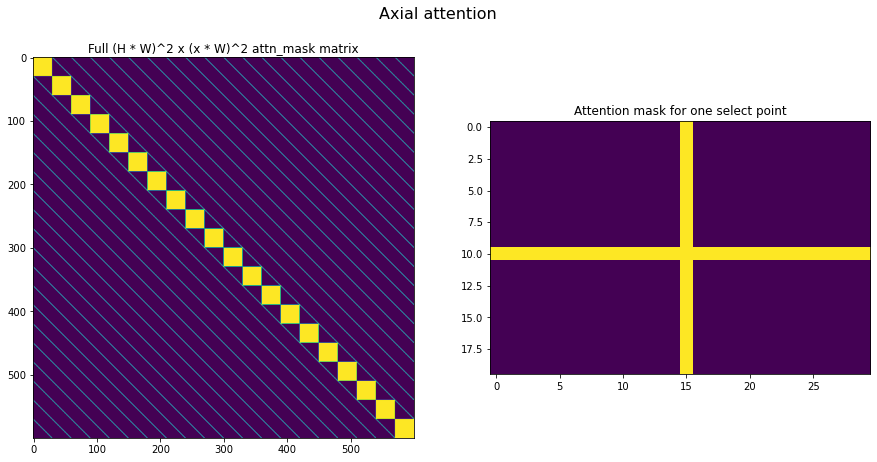

In [4]:
axial_pattern = AP.axial_2d_pattern(H, W)

fig, axs = plt.subplots(1, 2, figsize=(15, 7))
# full sparse matrix mask between every two points
# to be used in attn_mask
axs[0].imshow(axial_pattern)
axs[0].set_title("Full (H * W)^2 x (x * W)^2 attn_mask matrix")
# and a viaualization for a given point
axs[1].imshow(axial_pattern[middle_point].reshape(H, W))
axs[1].set_title("Attention mask for one select point")

fig.suptitle('Axial attention', fontsize=16)
plt.show()

## Local 2d distance

Let's now consider a variant of a local attention for 2d grids.

Let's use L2 distance for the following example, the norm can be changed via the `p` argument.

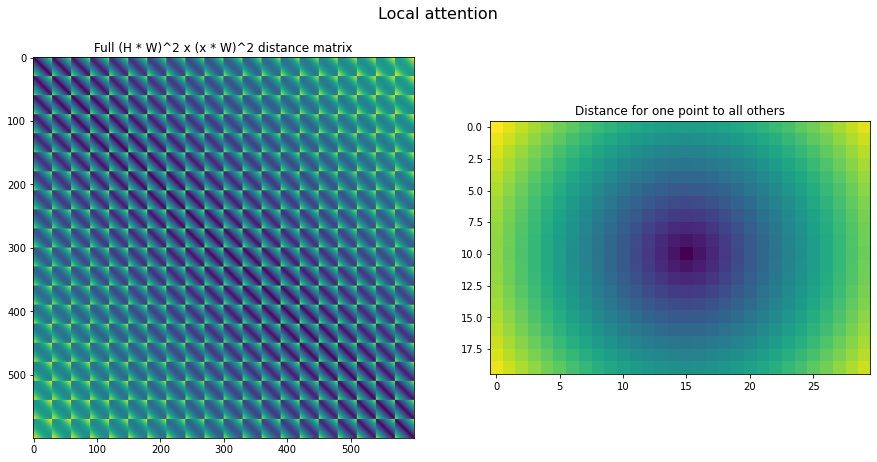

In [5]:
loc_2d_dist = AP.local_2d_distance(H, W, p=2.0)

fig, axs = plt.subplots(1, 2, figsize=(15, 7))
# full sparse matrix mask between every two points
# to be used in attn_mask
axs[0].imshow(loc_2d_dist)
axs[0].set_title("Full (H * W)^2 x (x * W)^2 distance matrix")
# and a viaualization for a given point
axs[1].imshow(loc_2d_dist[middle_point].reshape(H, W))
axs[1].set_title("Distance for one point to all others")

fig.suptitle('Local attention', fontsize=16)
plt.show()

We can either manually threshold the distance matrix ourselves, or use the convience function `local_2d_pattern` for generating the mask for us

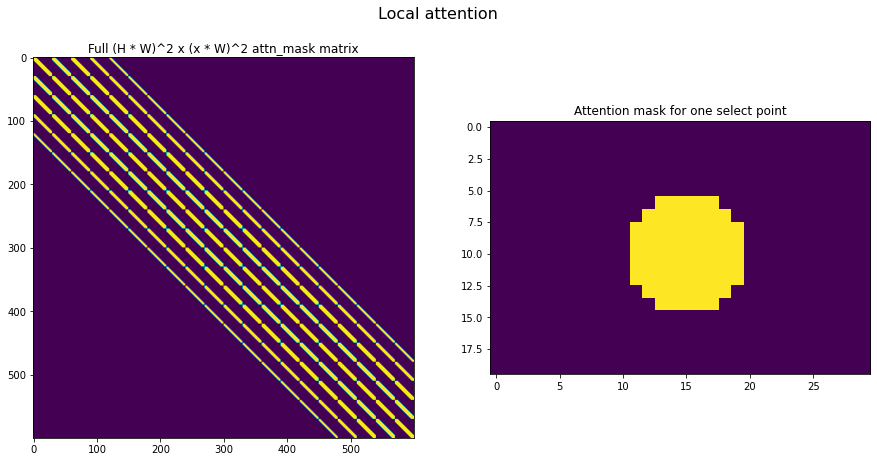

In [6]:
# this is equivalent to thresholding the result of local_2d_distance
# at distance d
loc_2d_dist = AP.local_2d_pattern(H, W, distance=5, p=2.0)

fig, axs = plt.subplots(1, 2, figsize=(15, 7))
# full sparse matrix mask between every two points
# to be used in attn_mask
axs[0].imshow(loc_2d_dist)
axs[0].set_title("Full (H * W)^2 x (x * W)^2 attn_mask matrix")
# and a viaualization for a given point
axs[1].imshow(loc_2d_dist[middle_point].reshape(H, W))
axs[1].set_title("Attention mask for one select point")

fig.suptitle('Local attention', fontsize=16)
plt.show()

## Random sampling from a probability distribution

Let's now create a random attention pattern that is sampled
from a gaussian distribution centered at each point.

For that, let's first create a Gaussian 2d distribution with variance `sigma`. 

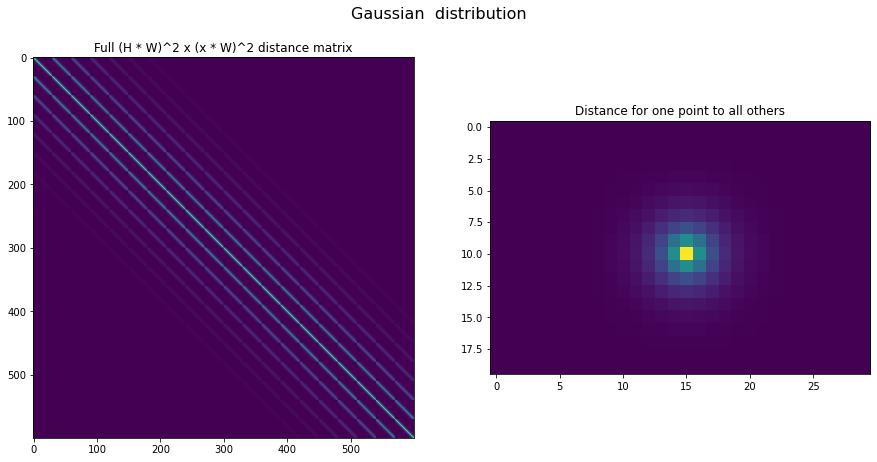

In [7]:
gaus_2d_dist = AP.local_2d_gausian_distribution(H, W, sigma=2)

fig, axs = plt.subplots(1, 2, figsize=(15, 7))
# full sparse matrix mask between every two points
# to be used in attn_mask
axs[0].imshow(gaus_2d_dist)
axs[0].set_title("Full (H * W)^2 x (x * W)^2 distance matrix")
# and a viaualization for a given point
axs[1].imshow(gaus_2d_dist[middle_point].reshape(H, W))
axs[1].set_title("Distance for one point to all others")

fig.suptitle('Gaussian  distribution', fontsize=16)
plt.show()

Let's now sample from it given those values as the probability distribution, keeping the resulting matrix 95% sparse

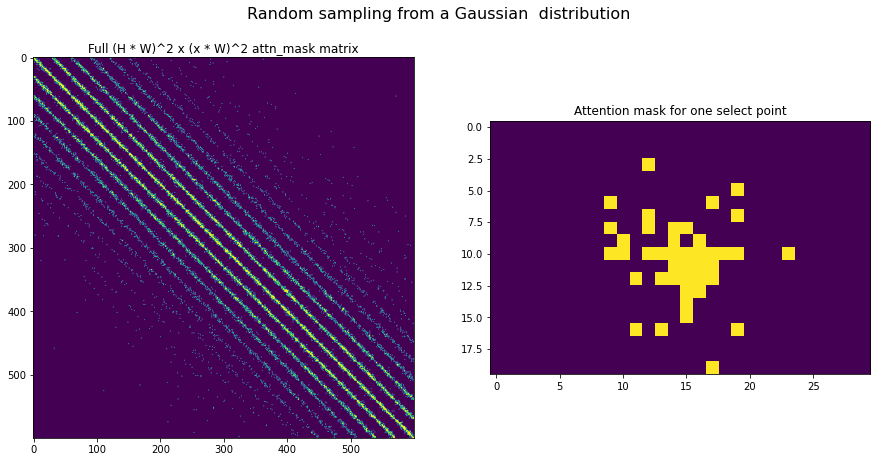

In [8]:
sparsity = 0.95
num_non_zeros = int((H * W) ** 2 * (1 - sparsity))
random_gaus_2d_pattern = AP.random_pattern_from_probability_matrix(gaus_2d_dist, num_non_zeros)

fig, axs = plt.subplots(1, 2, figsize=(15, 7))
# full sparse matrix mask between every two points
# to be used in attn_mask
axs[0].imshow(random_gaus_2d_pattern)
axs[0].set_title("Full (H * W)^2 x (x * W)^2 attn_mask matrix")
# and a viaualization for a given point
axs[1].imshow(random_gaus_2d_pattern[middle_point].reshape(H, W))
axs[1].set_title("Attention mask for one select point")

fig.suptitle('Random sampling from a Gaussian  distribution', fontsize=16)
plt.show()

## Combining arbitrary patterns

The power of this approach of considering those different instantiations of efficient transformers as just a sparse pattern is that it becomes trivial to combine multiple patterns together.

For example, using a combination of axial attention + local attention + random sampling can be done as simply as follows:

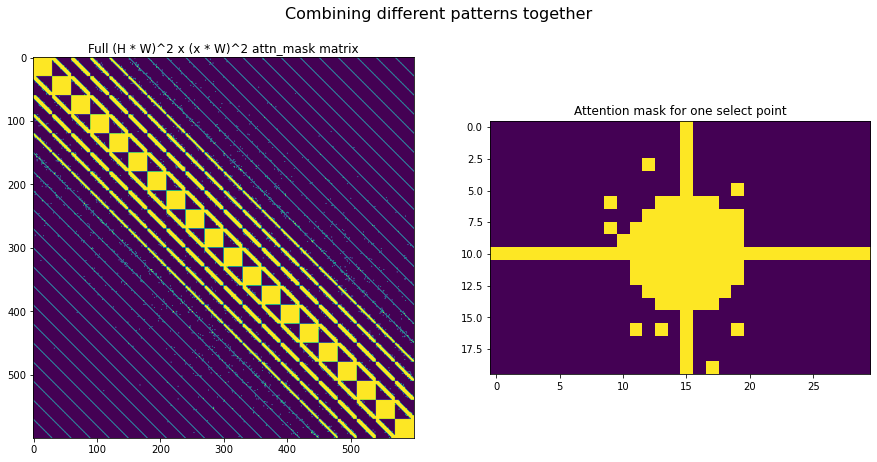

In [9]:
att_mask = axial_pattern | loc_2d_dist | random_gaus_2d_pattern

fig, axs = plt.subplots(1, 2, figsize=(15, 7))
# full sparse matrix mask between every two points
# to be used in attn_mask
axs[0].imshow(att_mask)
axs[0].set_title("Full (H * W)^2 x (x * W)^2 attn_mask matrix")
# and a viaualization for a given point
axs[1].imshow(att_mask[middle_point].reshape(H, W))
axs[1].set_title("Attention mask for one select point")

fig.suptitle('Combining different patterns together', fontsize=16)
plt.show()

Let's check the amount of sparsity that this pattern contains. The optimized implementations in `xformers` have competitive performance for sparsity patterns as low as 70%.

In [10]:
print(f"Sparsity level: {1 - float(att_mask.count_nonzero()) / att_mask.numel()}")

Sparsity level: 0.8392416666666667
